In [1]:
import pandas as pd
file = pd.read_csv("diabetic_data.csv")
df = pd.DataFrame(file)
df


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

#count duplicates 

df = df.drop_duplicates()
df = df.sort_values(['patient_nbr','encounter_id']).groupby('patient_nbr').tail(1)

# Replace the dataset's missing token "?" with np.nan
df = df.replace("?", np.nan)

# Drop columns that are >80% missing or known to be noisy/IDs
cols_to_drop = [
    'weight',            # >95% missing in many copies of this dataset
    'payer_code',        # heavy missingness
    'medical_specialty', # very high cardinality & missingness (optional)
    'encounter_id',      # identifier
    'patient_nbr'        # identifier
]
keep_cols = [c for c in df.columns if c not in cols_to_drop and c != 'readmitted']
df = df[keep_cols + ['readmitted']].copy()


In [3]:
print(df)

                   race  gender      age  admission_type_id  \
4780          Caucasian  Female  [50-60)                  1   
5827          Caucasian  Female  [50-60)                  3   
67608         Caucasian  Female  [80-90)                  1   
17494         Caucasian  Female  [80-90)                  1   
2270    AfricanAmerican  Female  [30-40)                  1   
...                 ...     ...      ...                ...   
99863         Caucasian  Female  [80-90)                  1   
95282             Other    Male  [60-70)                  1   
93651         Caucasian  Female  [80-90)                  1   
101748        Caucasian  Female  [40-50)                  1   
96147         Caucasian    Male  [40-50)                  2   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
4780                           1                    7                 3   
5827                           1                    1                 2   
67608             

In [4]:
# Target variable (binary: early 30-day readmission)
# '<30' -> 1 (positive); 'NO' and '>30' -> 0 (negative)
df['target'] = (df['readmitted'] == '<30').astype(int)
df = df.drop(columns=['readmitted'])


In [5]:
import re
import numpy as np
import pandas as pd

df_fe = df.copy()

# --- 1) ICD-9 helpers ---
def icd_bucket(code):
    if pd.isna(code):
        return 'unknown'
    code = str(code)
    # E/V codes first
    if code.startswith('E'):
        return 'injury_poison'
    if code.startswith('V'):
        return 'supplementary'
    # numeric groups
    try:
        val = float(code)
    except:
        return 'unknown'
    if 390 <= val <= 459 or val == 785: return 'circulatory'
    if 460 <= val <= 519 or val == 786: return 'respiratory'
    if 520 <= val <= 579 or val == 787: return 'digestive'
    if 580 <= val <= 629 or val == 788: return 'genitourinary'
    if 240 <= val <= 279:               return 'endocrine'
    if 710 <= val <= 739:               return 'musculoskeletal'
    if 780 <= val <= 799:               return 'symptoms_signs'
    if 800 <= val <= 999:               return 'injury_poison'
    if 140 <= val <= 239:               return 'neoplasms'
    if 290 <= val <= 319:               return 'mental'
    return 'other'

for c in ['diag_1','diag_2','diag_3']:
    df_fe[c+'_bucket'] = df_fe[c].apply(icd_bucket)

# primary dx bucket and counts per bucket across 1..3
df_fe['diag1_bucket'] = df_fe['diag_1_bucket']
bucket_cols = ['circulatory','respiratory','endocrine','genitourinary','digestive','neoplasms','injury_poison','mental','musculoskeletal','symptoms_signs','other','supplementary','unknown']
for b in bucket_cols:
    df_fe[f'num_{b}_dx'] = (df_fe[['diag_1_bucket','diag_2_bucket','diag_3_bucket']]==b).sum(axis=1)

# --- 2) Comorbidity-lite flags ---
def has_icd_range(code, lo, hi):
    try:
        v = float(code)
        return (v>=lo) & (v<=hi)
    except:
        return False

def any_icd_range(row, lo, hi):
    return any(has_icd_range(row[c], lo, hi) for c in ['diag_1','diag_2','diag_3'])

df_fe['cm_renal']   = df_fe.apply(lambda r: any_icd_range(r, 580, 589), axis=1)
df_fe['cm_chf']     = df_fe.apply(lambda r: any_icd_range(r, 428, 428), axis=1)
df_fe['cm_copd']    = df_fe.apply(lambda r: any_icd_range(r, 490, 496), axis=1)
df_fe['cm_cancer']  = df_fe.apply(lambda r: any_icd_range(r, 140, 239), axis=1)
df_fe['cm_liver']   = df_fe.apply(lambda r: any_icd_range(r, 570, 573), axis=1)
df_fe['cm_diab_cx'] = df_fe.apply(lambda r: any_icd_range(r, 250.4, 250.9), axis=1)  # diabetes w/ complications (approx)
df_fe['comorbidity_count'] = df_fe[['cm_renal','cm_chf','cm_copd','cm_cancer','cm_liver','cm_diab_cx']].sum(axis=1)

# --- 3) Utilization features ---
df_fe['prior_util_sum'] = df_fe[['number_inpatient','number_emergency','number_outpatient']].sum(axis=1)
df_fe['inpatient_ge_2'] = (df_fe['number_inpatient'] >= 2).astype(int)
df_fe['emergency_ge_2'] = (df_fe['number_emergency'] >= 2).astype(int)
df_fe['any_util_ge_3']  = (df_fe['prior_util_sum']  >= 3).astype(int)

# --- 4) Discharge context flags (IDs per dataset documentation) ---
# (Adjust mapping to your codebook if needed)
df_fe['discharge_home']       = df_fe['discharge_disposition_id'].isin([1]).astype(int)
df_fe['discharge_home_health']= df_fe['discharge_disposition_id'].isin([6]).astype(int)
df_fe['discharge_snf_rehab']  = df_fe['discharge_disposition_id'].isin([3,4,5,23,24,25,26]).astype(int)
df_fe['left_ama']             = df_fe['discharge_disposition_id'].isin([7]).astype(int)

# Interaction
df_fe['snf_short_los'] = df_fe['discharge_snf_rehab'] * (df_fe['time_in_hospital'] <= 3)

# --- 5) Medication complexity & change ---
df_fe['polypharmacy_ge_10'] = (df_fe['num_medications'] >= 10).astype(int)
df_fe['any_diabetes_med']   = (df_fe['diabetesMed']=='Yes').astype(int)
df_fe['insulin_started_or_changed'] = ((df_fe['insulin'].astype(str)!='No') & (df_fe['change'].astype(str)=='Ch')).astype(int)

# --- 6) Glycemic control ---
df_fe['a1c_high']          = df_fe['A1Cresult'].isin(['>7','>8']).astype(int)
df_fe['a1c_measured_flag'] = df_fe['A1Cresult'].isin(['>7','>8','Norm']).astype(int)
df_fe['glu_high']          = df_fe['max_glu_serum'].isin(['>200','>300']).astype(int)
df_fe['a1c_high_x_anydm']  = df_fe['a1c_high'] * df_fe['any_diabetes_med']

# --- 7) Stay intensity ---
los = df_fe['time_in_hospital'].clip(lower=1)
df_fe['labs_per_day']  = df_fe['num_lab_procedures'] / los
df_fe['procs_per_day'] = df_fe['num_procedures'] / los
df_fe['meds_per_day']  = df_fe['num_medications'] / los
df_fe['los_ge_7']      = (df_fe['time_in_hospital'] >= 7).astype(int)

# --- 8) Age midpoints (optional) ---
age_mid = {
    '[0-10)':5,'[10-20)':15,'[20-30)':25,'[30-40)':35,'[40-50)':45,
    '[50-60)':55,'[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95
}
df_fe['age_mid'] = df_fe['age'].map(age_mid).astype(float)
df_fe['age_ge_75'] = (df_fe['age_mid'] >= 75).astype(int)


In [6]:
df = df_fe
# Feature splits
y = df['target'].values 
X = df.drop(columns=['target'])

# Identify categorical vs numeric
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# 6) Train/valid/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) Preprocess: one-hot encode categoricals, pass-through numerics
# handle_unknown='ignore' is important due to high-cardinality ICD codes (diag_1/2/3)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)

# 8) Class imbalance handling
# scale_pos_weight = (#neg / #pos) is a good starting point for XGBoost
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)


xgboost version: 3.0.5
Test AUROC: 0.715
Test AUPRC: 0.113
              precision    recall  f1-score   support

           0      0.974     0.710     0.821     13659
           1      0.088     0.591     0.153       645

    accuracy                          0.705     14304
   macro avg      0.531     0.650     0.487     14304
weighted avg      0.934     0.705     0.791     14304

Confusion matrix at:0.49
 [[9701 3958]
 [ 264  381]]


/Users/martiin/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


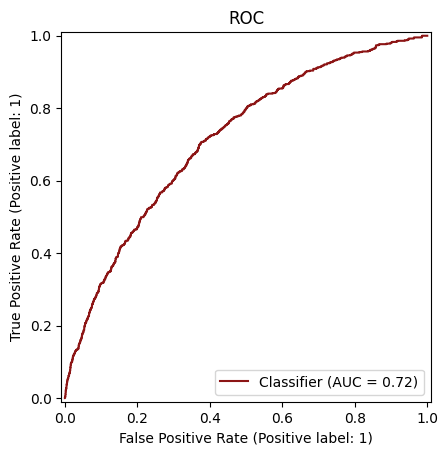

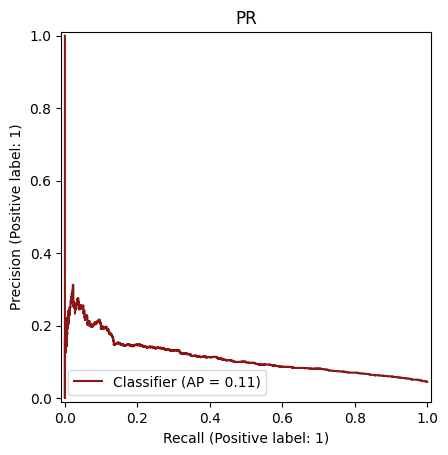


Top 20 features by gain:
                         feature         gain
440              inpatient_ge_2  1302.009766
418            number_inpatient   253.708740
410    discharge_disposition_id   152.665039
408  diag1_bucket_supplementary   143.517975
439              prior_util_sum   138.619843
442              discharge_home   135.803558
444         discharge_snf_rehab   128.601212
455                     age_mid   126.241409
409           admission_type_id   109.875290
133                  diag_2_198   106.542908
447            any_diabetes_med   104.594910
7                   gender_Male    99.253899
54                   diag_1_402    97.377800
428      num_musculoskeletal_dx    96.064201
376     diag_1_bucket_neoplasms    95.355598
349                glipizide_Up    91.176895
308                  diag_3_780    89.580803
38                diag_1_250.82    89.196465
227                  diag_2_V10    86.160194
2                race_Caucasian    86.084579


In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import xgboost as xgb

print("xgboost version:", xgb.__version__)

# 1) Split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2) Encode (use your ColumnTransformer 'preprocess')
X_tr_enc  = preprocess.fit_transform(X_tr, y_tr)
X_val_enc = preprocess.transform(X_val)
X_te_enc  = preprocess.transform(X_test)

# 3) Model — put early_stopping_rounds IN THE CONSTRUCTOR for xgboost>=2
xgb_clf = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",      # better under imbalance
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    early_stopping_rounds=50  # <-- here (not in .fit)
)

# 4) Fit (no callbacks; just provide eval_set)
xgb_clf.fit(
    X_tr_enc, y_tr,
    eval_set=[(X_tr_enc, y_tr), (X_val_enc, y_val)],
    verbose=False
)

# 5) Evaluate
y_prob = xgb_clf.predict_proba(X_te_enc)[:, 1]
auroc = roc_auc_score(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)
print(f"Test AUROC: {auroc:.3f}")
print(f"Test AUPRC: {auprc:.3f}")

thr = 0.490
y_pred = (y_prob >= thr).astype(int)
print(classification_report(y_test, y_pred, digits=3))
print(f"Confusion matrix at:{thr}\n", confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_prob, color="#8C1515"); plt.title("ROC"); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob,color="#8C1515"); plt.title("PR"); plt.show()

# 6) Feature importance
ohe = preprocess.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

booster = xgb_clf.get_booster()
gain = booster.get_score(importance_type='gain')
idx_to_name = {f"f{i}": name for i, name in enumerate(feature_names)}
imp = pd.DataFrame([(idx_to_name.get(k, k), v) for k, v in gain.items()],
                   columns=["feature", "gain"]).sort_values("gain", ascending=False)
print("\nTop 20 features by gain:\n", imp.head(20))


/var/folders/6k/_8l_9_0d7pnctxt08lzd613w0000gn/T/ipykernel_38608/1026805893.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby('inpatient_bin')['target'].mean() * 100


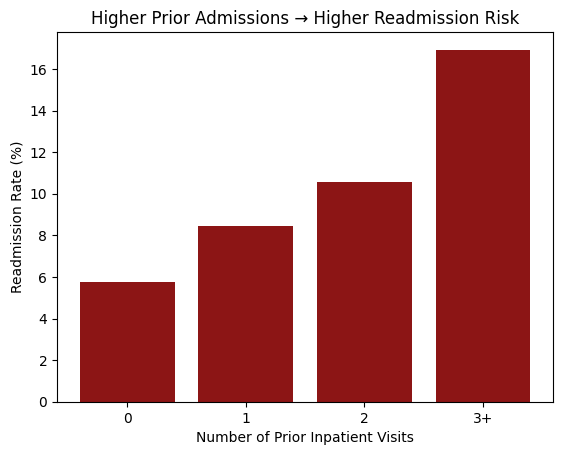

In [8]:
import pandas as pd, matplotlib.pyplot as plt

bins = [0,1,2,3,10]
labels = ['0','1','2','3+']
df['inpatient_bin'] = pd.cut(df['number_inpatient'], bins=bins, labels=labels)
rate = df.groupby('inpatient_bin')['target'].mean() * 100

plt.bar(rate.index, rate.values, color="#8C1515")
plt.xlabel("Number of Prior Inpatient Visits")
plt.ylabel("Readmission Rate (%)")
plt.title("Higher Prior Admissions → Higher Readmission Risk")
plt.show()


/var/folders/6k/_8l_9_0d7pnctxt08lzd613w0000gn/T/ipykernel_38608/777530077.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='time_in_hospital', data=df,


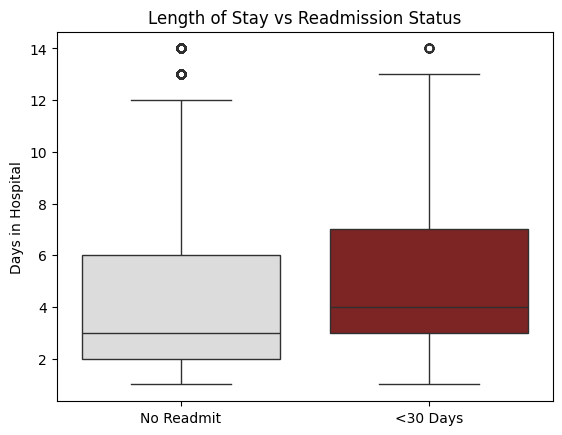

In [9]:
import seaborn as sns
sns.boxplot(x='target', y='time_in_hospital', data=df,
            palette=['#dcdcdc','#8C1515'])
plt.xticks([0,1], ['No Readmit','<30 Days'])
plt.title("Length of Stay vs Readmission Status")
plt.xlabel("")
plt.ylabel("Days in Hospital")
plt.show()


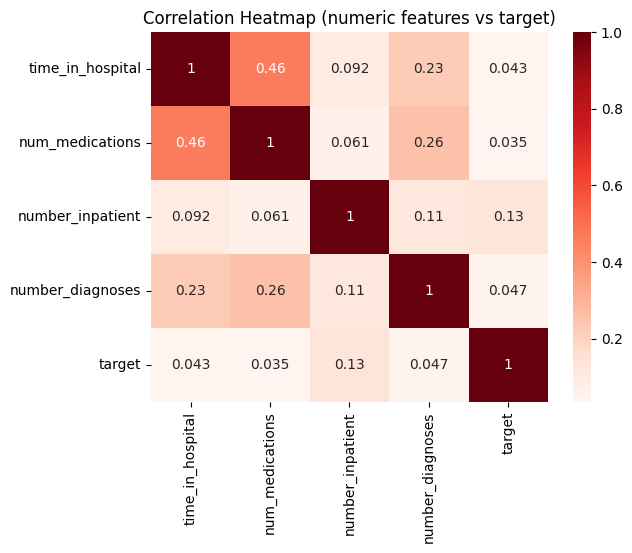

In [10]:
corr = df[['time_in_hospital','num_medications','number_inpatient',
           'number_diagnoses','target']].corr()
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title("Correlation Heatmap (numeric features vs target)")
plt.show()


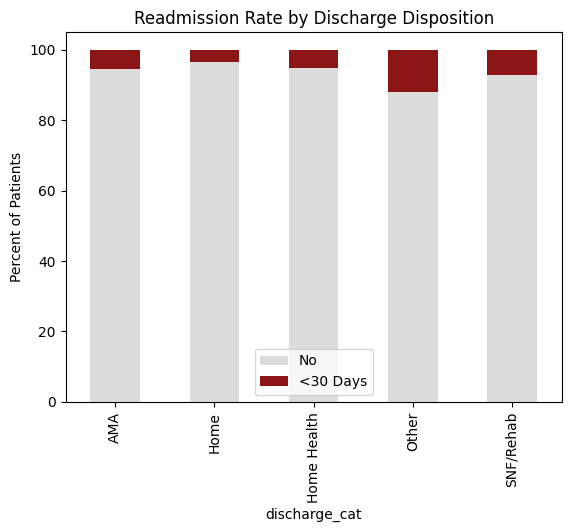

In [11]:
df['discharge_cat'] = df['discharge_disposition_id'].map({
    1:'Home', 3:'SNF/Rehab', 7:'AMA', 6:'Home Health', 5:'Other'
})
pivot = pd.crosstab(df['discharge_cat'], df['target'], normalize='index')*100
pivot[[0,1]].plot(kind='bar', stacked=True, color=['#dcdcdc','#8C1515'])
plt.legend(['No','<30 Days'])
plt.title("Readmission Rate by Discharge Disposition")
plt.ylabel("Percent of Patients")
plt.show()


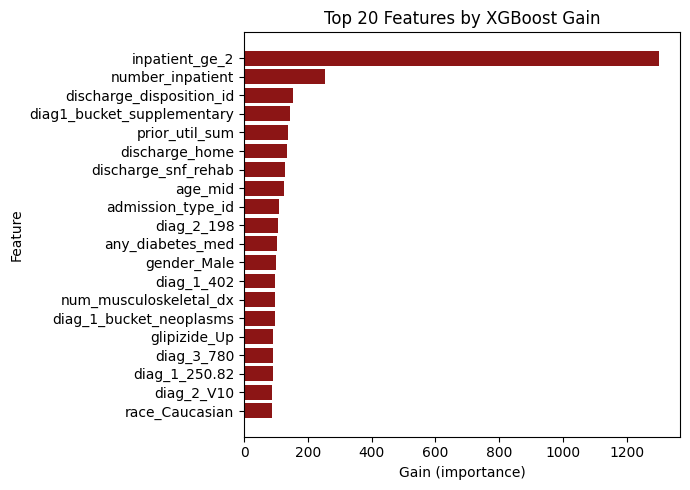

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Paste your top 20 features
data = {
    'feature': [
        'inpatient_ge_2', 'number_inpatient', 'discharge_disposition_id',
        'diag1_bucket_supplementary', 'prior_util_sum', 'discharge_home',
        'discharge_snf_rehab', 'age_mid', 'admission_type_id', 'diag_2_198',
        'any_diabetes_med', 'gender_Male', 'diag_1_402', 'num_musculoskeletal_dx',
        'diag_1_bucket_neoplasms', 'glipizide_Up', 'diag_3_780', 'diag_1_250.82',
        'diag_2_V10', 'race_Caucasian'
    ],
    'gain': [
        1302.01, 253.71, 152.67, 143.52, 138.62, 135.80, 128.60, 126.24, 109.88,
        106.54, 104.59, 99.25, 97.38, 96.06, 95.36, 91.18, 89.58, 89.20, 86.16, 86.08
    ]
}

df_imp = pd.DataFrame(data)

# Plot
plt.figure(figsize=(7,5))
plt.barh(df_imp['feature'], df_imp['gain'], color="#8C1515")
plt.xlabel('Gain (importance)')
plt.ylabel('Feature')
plt.title('Top 20 Features by XGBoost Gain')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()


In [14]:
!pip install shap


  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.0/556.0 kB 14.7 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.9 MB/s eta 0:00:00
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 27.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [16]:
import numpy as np
import shap

# 1) Encode test set with the same preprocessor
X_test_enc = preprocess.transform(X_test)

# 2) Get feature names in the same order as X_test_enc
ohe = preprocess.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

# 3) Get predicted probabilities for all test patients
y_prob_all = xgb_clf.predict_proba(X_test_enc)[:, 1]

# 4) SHAP explainer for local (per-patient) contributions
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_enc, check_additivity=False)


In [17]:
def risk_label(p):
    """Map probability to Low / Moderate / High."""
    if p < 0.20:
        return "Low"
    elif p < 0.50:
        return "Moderate"
    else:
        return "High"


def top_features_for_patient(idx, k=4):
    """Return top-k contributing features for patient idx using SHAP."""
    shap_row = shap_values[idx]                 # 1D array (n_features,)
    top_idx = np.argsort(np.abs(shap_row))[::-1][:k]

    top_feats = []
    for j in top_idx:
        top_feats.append({
            "feature": feature_names[j],
            "shap_value": float(shap_row[j])    # >0 pushes risk up, <0 pushes risk down
        })
    return top_feats


In [20]:
# indices sorted by predicted probability
sorted_idx = np.argsort(y_prob_all)

# 2 lowest-risk patients
low_idx1, low_idx2 = sorted_idx[0], sorted_idx[1]

# 1 highest-risk patient
high_idx = sorted_idx[-1]

# 1 medium-risk: probability closest to ~0.35 (adjust if needed)
target_mid = 0.5
medium_idx = int(np.argmin(np.abs(y_prob_all - target_mid)))

example_indices = [low_idx1, low_idx2, medium_idx, high_idx]
example_indices


[np.int64(1438), np.int64(11663), 9533, np.int64(11734)]

In [21]:
import json

patient_cards = []

for idx in example_indices:
    p = float(y_prob_all[idx])
    card = {
        "patient_index": int(idx),           # index within X_test
        "true_label": int(y_test[idx]),      # 0/1 actual outcome
        "predicted_probability": p,
        "risk_level": risk_label(p),
        "top_features": top_features_for_patient(idx, k=4)
    }
    patient_cards.append(card)

# JSON for Nick / Vision Pro app
with open("patient_cards.json", "w") as f:
    json.dump(patient_cards, f, indent=2)

# Optional: human-readable text file
with open("patient_cards.txt", "w") as f:
    for card in patient_cards:
        f.write(f"Patient {card['patient_index']} (true={card['true_label']}):\n")
        f.write(f"  Predicted risk: {card['predicted_probability']:.3f} "
                f"({card['risk_level']})\n")
        f.write("  Top features:\n")
        for feat in card["top_features"]:
            direction = "↑ risk" if feat["shap_value"] > 0 else "↓ risk"
            f.write(f"    - {feat['feature']}: "
                    f"{feat['shap_value']:.4f} ({direction})\n")
        f.write("\n")

print("Wrote patient_cards.json and patient_cards.txt")


Wrote patient_cards.json and patient_cards.txt


In [24]:
!pip install shap
import numpy as np
import pandas as pd
import json
import shap

# 1) Encode the test set and compute SHAP values
X_test_enc = preprocess.transform(X_test)   # sparse OK
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_enc, check_additivity=False)

# Make sure shap_values is (n_samples, n_features)
shap_values = np.asarray(shap_values)

# Get feature names in the same order XGBoost sees them
ohe = preprocess.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

# 2) Get predicted probabilities for the test set
y_prob_all = xgb_clf.predict_proba(X_test_enc)[:, 1]

def risk_bucket(p):
    """Map probability to Low / Moderate / High buckets."""
    if p >= 0.70:
        return "High"
    elif p >= 0.30:
        return "Moderate"
    else:
        return "Low"

# 3) Small ICD-9 label dictionary (extend as needed)
icd_labels = {
    "250.82": "Diabetes with other specified manifestations",
    "493": "Asthma",
    "V10": "History of malignant neoplasm",
    # Add more codes here if they show up in top features
}

# 4) Helper to turn one feature into the JSON-format block
def summarize_feature(feat_name, row_raw, enc_val, shap_val):
    direction = "up" if shap_val > 0 else "down" if shap_val < 0 else "neutral"

    raw_value = None
    label = feat_name
    reason = "This feature influenced the model's risk estimate for this patient."

    # ---- SPECIAL CASES / NICE LABELS ----
    if feat_name == "number_inpatient":
        raw_value = int(row_raw["number_inpatient"])
        label = f"Prior inpatient stays: {raw_value}"
        reason = "More prior inpatient stays are linked to higher readmission risk in this dataset."

    elif feat_name == "prior_util_sum":
        raw_value = int(row_raw["prior_util_sum"])
        label = f"Total prior hospital/ER visits: {raw_value}"
        reason = "High overall utilization (hospital + ER visits) is associated with higher readmission risk."

    elif feat_name == "discharge_disposition_id":
        raw_value = int(row_raw["discharge_disposition_id"])
        # Basic mapping you can improve later
        disp_map = {
            1: "Home",
            3: "Skilled nursing/rehab",
            5: "Other facility",
        }
        disp_label = disp_map.get(raw_value, f"Code {raw_value}")
        label = f"Discharge destination: {disp_label}"
        reason = "Certain discharge destinations, such as rehab facilities or non-home settings, are linked to higher risk."

    elif feat_name == "discharge_snf_rehab":
        raw_value = int(row_raw["discharge_snf_rehab"])
        label = "Discharge to SNF/rehab: Yes" if raw_value == 1 else "Discharge to SNF/rehab: No"
        reason = "Being discharged to a rehab or skilled nursing facility usually indicates higher complexity and risk."

    elif feat_name == "a1c_high":
        raw_value = int(row_raw["a1c_high"])
        label = "A1C during stay: Above goal" if raw_value == 1 else "A1C during stay: At/near goal"
        reason = "Poor glycemic control is associated with higher chance of early readmission."

    elif feat_name == "any_diabetes_med":
        raw_value = int(row_raw["any_diabetes_med"])
        label = "On diabetes medications: Yes" if raw_value == 1 else "On diabetes medications: No"
        reason = "Changes in diabetes medications can signal unstable disease control."

    elif feat_name == "age_mid":
        raw_value = float(row_raw["age_mid"])
        label = f"Age (mid of bracket): {raw_value:.0f} years"
        reason = "Older age is generally associated with higher risk of readmission."

    elif feat_name.startswith("race_"):
        # e.g., race_Caucasian
        category = feat_name.split("race_")[1]
        raw_value = int(enc_val)  # 1 if this race, 0 otherwise
        if raw_value == 1:
            label = f"Race: {category}"
        else:
            label = f"Race: not {category}"
        reason = "Some racial/ethnic groups may have different readmission patterns due to social and clinical factors."

    elif feat_name.startswith(("diag_1_", "diag_2_", "diag_3_")):
        # One-hot diagnostic bucket like diag_2_493
        parts = feat_name.split("_", 2)   # ["diag", "2", "493"]
        slot = parts[1]                   # "1", "2", or "3"
        code = parts[2]                   # "493", "250.82", etc.
        icd_name = icd_labels.get(code, f"ICD-9 {code}")
        pos_map = {"1": "Primary", "2": "Secondary", "3": "Tertiary"}
        position = pos_map.get(slot, "Diagnosis")

        raw_value = int(enc_val)  # 1 if this code present
        if raw_value == 1:
            label = f"{position} diagnosis: {icd_name} ({code})"
        else:
            label = f"{position} diagnosis: not {icd_name} ({code})"
        reason = "Diagnosis categories capture the underlying condition mix, which affects readmission risk."

    # ---- FALLBACK: generic label ----
    if raw_value is None:
        # Try to read from raw row; if missing, fall back to encoded value
        raw_value = row_raw.get(feat_name, enc_val)
        label = f"{feat_name} = {raw_value}"

    # Normalize numeric types so they’re JSON-serializable
    if isinstance(raw_value, (np.floating, np.integer)):
        raw_value = float(raw_value)

    return {
        "id": feat_name,
        "raw_value": raw_value,
        "direction": direction,
        "shap_value": float(shap_val),
        "label": label,
        "reason": reason,
    }

# 5) Choose 4 example patients
#    2 lowest risk, 1 moderate-ish, 1 highest risk.
idx_sorted = np.argsort(y_prob_all)
low_indices = idx_sorted[:2]
high_index = idx_sorted[-1]
mid_index = idx_sorted[len(idx_sorted) // 2]
selected_indices = [int(low_indices[0]), int(low_indices[1]),
                    int(mid_index), int(high_index)]

print("Selected patient row indices:", selected_indices)

patient_cards = []

for row_id in selected_indices:
    # Raw row & encoded row
    row_raw = X_test.iloc[row_id]
    # X_test_enc is sparse for OneHotEncoder(sparse_output=True)
    row_enc = X_test_enc[row_id]
    if hasattr(row_enc, "toarray"):
        row_enc = row_enc.toarray().ravel()
    else:
        row_enc = np.asarray(row_enc).ravel()

    shap_row = shap_values[row_id]

    # Top-k features by absolute SHAP value
    top_k = 4
    idx_top = np.argsort(np.abs(shap_row))[::-1][:top_k]

    top_features = []
    for j in idx_top:
        feat_name = feature_names[j]
        shap_val = shap_row[j]
        enc_val = row_enc[j]
        top_features.append(
            summarize_feature(feat_name, row_raw, enc_val, shap_val)
        )

    prob = float(y_prob_all[row_id])
    risk = risk_bucket(prob)

    # y_test might be a NumPy array or a pandas Series
    if hasattr(y_test, "iloc"):
        true_label = int(y_test.iloc[row_id])
    else:
        true_label = int(y_test[row_id])

    patient_cards.append({
        "patient_index": int(row_id),
        "true_label": true_label,
        "predicted_probability": prob,
        "risk_level": risk,
        "top_features": top_features,
    })


# 6) Save JSON for Vision Pro app
with open("patient_cards.json", "w") as f:
    json.dump(patient_cards, f, indent=2)

print("Wrote patient_cards.json with", len(patient_cards), "patients.")

# 7) Also save a flat CSV version (one row per patient-feature)
flat_rows = []
for card in patient_cards:
    for feat in card["top_features"]:
        flat_rows.append({
            "patient_index": card["patient_index"],
            "true_label": card["true_label"],
            "predicted_probability": card["predicted_probability"],
            "risk_level": card["risk_level"],
            "feature_id": feat["id"],
            "raw_value": feat["raw_value"],
            "direction": feat["direction"],
            "shap_value": feat["shap_value"],
            "label": feat["label"],
            "reason": feat["reason"],
        })

df_flat = pd.DataFrame(flat_rows)
df_flat.to_csv("patient_cards_flat.csv", index=False)

print("Wrote patient_cards_flat.csv with", len(df_flat), "rows.")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Selected patient row indices: [1438, 11663, 1408, 11734]
Wrote patient_cards.json with 4 patients.
Wrote patient_cards_flat.csv with 16 rows.
